<a href="https://colab.research.google.com/github/ce888-sr/CE888_Lab/blob/main/A2/CE888_A2_Model_NoWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Activation, Dropout, Dense, Conv2D, Flatten, Dropout, ReLU, MaxPool2D, BatchNormalization, SeparableConv2D, Add, GlobalAvgPool2D, GlobalAveragePooling2D
import cv2

In [2]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
#download and unzip files
#!unzip  "/content/gdrive/My Drive/Training (2).zip"
#!unzip  "/content/gdrive/My Drive/Test (1).zip"

In [4]:
train_directory = "/content/Training" #set directory to where the extracted datsets are saved
test_directory = '/content/Test'

In [5]:
#set image size and batch size
image_size = (254, 254)
batch_size = 32

In [6]:
#add data augmentation techniques to the training datagen and add rescale to all datagens
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8,0.9],
    validation_split=0.2)


val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
#create datasets for training, validation and testing
train_ds = train_datagen.flow_from_directory(
    train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed = 1337,
    subset='training') # set as training data

val_ds = val_datagen.flow_from_directory(
    train_directory, # same directory as training data
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed = 1337,
    subset='validation') # set as validation data

test_ds = test_datagen.flow_from_directory(test_directory,
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           class_mode='binary',
                                           shuffle = False)

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [8]:
#load pre trained Xception model
from keras.models import Model
from tensorflow.keras.applications import Xception # TensorFlow ONLY
from tensorflow.keras import regularizers

from keras.models import Model
#load pre trained Xception model
base_model = Xception(input_shape=(254, 254, 3), include_top=False) #define model
x = base_model.output

# add additional layers
x = GlobalAveragePooling2D()(x) #convert features to vectors
x = Dropout(0.5)(x) # add dropout 0.5
x = Dense(2048, activation = 'relu')(x)
x = Dropout(0.5)(x) # add dropout 0.5
output = Dense(1, activation='sigmoid')(x) #2 classes

#freeze the pre-trained base_model
for layer in base_model.layers: 
        layer.trainable = False 

model = Model(base_model.input, output)

#model.summary()

83689472/83683744 [==============================] - 1s 0us/step


In [9]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-6), #low learning rate 
                  loss='binary_crossentropy',  # binary_crossentropy for binary classifier
                  metrics=['accuracy'])

In [11]:
#set early stopping and model weights checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = 'top_model.hdf5'
callbacks_list = [
    EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True), #patience set to 5 to stop overfitting
    ModelCheckpoint(filepath, monitor ="val_loss", mode="min", save_best_only=True)]

In [12]:
epochs = 30
history = model.fit(train_ds,
          steps_per_epoch = 100, 
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=val_ds,
          #class_weight=class_weight,
          callbacks = callbacks_list)

Epoch 1/30
100/100 [==============================] - 142s 1s/step - loss: 0.6915 - accuracy: 0.6011 - val_loss: 0.6325 - val_accuracy: 0.6358
Epoch 2/30
100/100 [==============================] - 105s 1s/step - loss: 0.6310 - accuracy: 0.6531 - val_loss: 0.5827 - val_accuracy: 0.6415
Epoch 3/30
100/100 [==============================] - 104s 1s/step - loss: 0.6053 - accuracy: 0.6778 - val_loss: 0.5419 - val_accuracy: 0.7188
Epoch 4/30
100/100 [==============================] - 104s 1s/step - loss: 0.5728 - accuracy: 0.7095 - val_loss: 0.5070 - val_accuracy: 0.8740
Epoch 5/30
100/100 [==============================] - 104s 1s/step - loss: 0.5547 - accuracy: 0.7357 - val_loss: 0.4779 - val_accuracy: 0.9780
Epoch 6/30
100/100 [==============================] - 104s 1s/step - loss: 0.5235 - accuracy: 0.7801 - val_loss: 0.4482 - val_accuracy: 0.9987
Epoch 7/30
100/100 [==============================] - 104s 1s/step - loss: 0.4932 - accuracy: 0.7973 - val_loss: 0.4241 - val_accuracy: 0.9983

In [14]:
from sklearn.metrics import accuracy_score

testLabels = test_ds.classes.astype('int32')


## Test Accuracy
predictions = model.predict(test_ds)
y_pred = np.asarray(predictions).astype('int32').reshape((-1, 1))
y_pred = [1 if i> 0.5 else 0 for i in predictions]

test_acc = accuracy_score(testLabels, y_pred)

print(test_acc)

0.7123128699083208


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

fire_eval = confusion_matrix(testLabels, y_pred)
print(fire_eval)

target_names = ['Fire', 'No Fire']
print(classification_report(testLabels, y_pred, target_names=target_names))

[[4089 1048]
 [1431 2049]]
              precision    recall  f1-score   support

        Fire       0.74      0.80      0.77      5137
     No Fire       0.66      0.59      0.62      3480

    accuracy                           0.71      8617
   macro avg       0.70      0.69      0.70      8617
weighted avg       0.71      0.71      0.71      8617



In [16]:
tp = fire_eval[0][0]
fp = fire_eval[0][1]
tn = fire_eval[1][0]
fn = fire_eval[1][1]
conmat = np.array([[tp, fn], [fp, tn]], dtype=int)

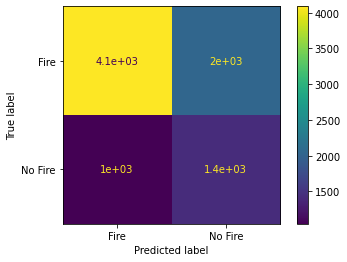

In [19]:
#plotconfusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cmat = ConfusionMatrixDisplay(confusion_matrix=conmat,

                              display_labels=target_names)
cmat.plot() 

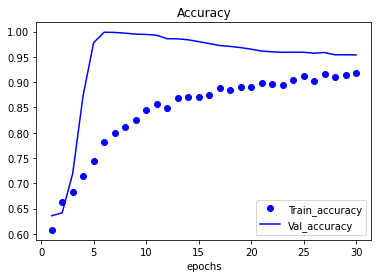

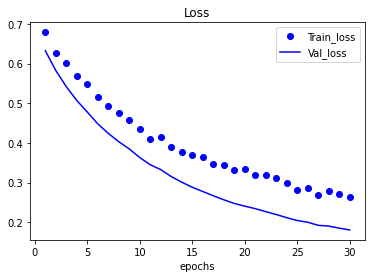

In [20]:
#create accuracy and loss plots over epochs
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Train_accuracy')
plt.plot(epochs, val_acc, 'b', label='Val_accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train_loss')
plt.plot(epochs, val_loss, 'b', label='Val_loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()

plt.show()